#**Model from Scratch**

In the following section we present how a model made from scratch can be used to identify silos in images with good accuracy. We will start by importing useful Python libraries and then we will create a model, train it with our training dataset and evaluate its performance on validation and test datasets.

In [621]:
# Importing useful libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

The following cell can be run in case you do not have the required files to run the code without errors. Uncomment to run if needed.

In [ ]:
# drive.mount('/content/content/Drive/')
# zip_ref = zipfile.ZipFile("/content/Drive/My Drive/imgs/ai_ready.zip")
# zip_ref.extractall("/tmp")
# zip_ref.close()

We can now create our model with some convolution, pooling and other layers. There is no specific rule here so we experimented with a few models to see what we get.

In [622]:
# Creating model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc1 = nn.Linear(128 * 3 * 3, 1000)
        self.fc2 = nn.Linear(1000, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

model = Net()

The average mean and standard deviation of millions of images can be used to normalize our data later.

In [623]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [624]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

Here we create a dataset class, transforming our images and getting back both the image and the label. After that, we create our training, validation and test datasets.

In [625]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, transform = transforms.Compose([transforms.Resize((224, 224)),
                                                                                     transforms.ToTensor(),transforms.Normalize(mean, std)])):
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.transform = transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
        
      if self.transform:
        image = self.transform(image)

      return image, label

In [626]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img)
data_validation = Data(csv_validation, image_dir=img)
data_test = Data(csv_test, image_dir=img)

We will introduce useful functions for the training process of our model, where we calculate the loss and the success rate.

In [ ]:
# Calculating loss
def calculate_loss(model, dataloader, batch_size=16):
    loss_fn = nn.CrossEntropyLoss()
    loss_epoch_test = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_test += loss
            
    return loss_epoch_test.item()

In [ ]:
# Calculating success rate
def success_rate(model, data, batch_size):
    N = len(data)
    counter = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            target = torch.zeros((min(len(labels), batch_size)))
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            
            i=0
            
            for output in outputs:
                if torch.argmax(output) == target[i]:
                    counter = counter + 1
                i = i + 1
                
            l = len(target)
          
    rate = (counter / ((N-1) * batch_size + l)) * 100

    return rate

With all of our functions ready, we can choose our device (CPU or GPU if available) and train our model while experimenting over different parameters, such as the number of epochs, the batch size and the optimizer learning rate.

In [ ]:
# Setting our device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training the model
def train(model, loss_fn, epochs, batch_size):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle=True)
    dataloader_validation = DataLoader(data_validation, batch_size = batch_size, shuffle=True) 
    training_loss = []
    validation_loss = []
    success_rate_ = [0]

    for epoch in tqdm(range(epochs), desc = "Total Progress: "):
        loss_epoch_train = 0
        
        for inputs, labels in dataloader_train:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]

            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
      
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_train += loss
            loss.backward()
            optimizer.step()
            
        print("Training Loss: {0}".format(loss_epoch_train.cpu().detach()))
        training_loss.append(loss_epoch_train.cpu().detach())
    
        val_loss = calculate_loss(model, dataloader_validation, batch_size)
        print("Validation Loss: {0}".format(val_loss))
        validation_loss.append(val_loss)
     
        accuracy_rate = success_rate(model, dataloader_validation, batch_size)
        print("Model accuracy: {0} %".format(accuracy_rate))
        success_rate_.append(accuracy_rate)
        
        print("Epoch done.")
        print("-------------------------------------")
            
    
    plt.plot(training_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Training Loss")
    plt.title("Evolution of training loss with number of epochs")
    plt.show()
    
    plt.plot(validation_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Validation Loss")
    plt.title("Evolution of validation loss with number of epochs")
    plt.show()
    
    plt.plot(success_rate_)
    plt.xlabel("Epoch number")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Evolution of our model's accuracy with number of epochs")
    plt.show()
    
    return model

Total Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 146.57948303222656
Validation Loss: 42.1831169128418
Model accuracy: 80.0 %
Epoch done.
-------------------------------------
Training Loss: 140.96298217773438
Validation Loss: 42.59151840209961
Model accuracy: 82.25 %
Epoch done.
-------------------------------------
Training Loss: 137.9674530029297
Validation Loss: 41.86109924316406
Model accuracy: 80.75 %
Epoch done.
-------------------------------------
Training Loss: 134.32664489746094
Validation Loss: 39.930877685546875
Model accuracy: 82.5 %
Epoch done.
-------------------------------------
Training Loss: 130.6981964111328
Validation Loss: 39.01344299316406
Model accuracy: 82.25 %
Epoch done.
-------------------------------------
Training Loss: 124.55684661865234
Validation Loss: 39.0976676940918
Model accuracy: 83.75 %
Epoch done.
-------------------------------------
Training Loss: 118.81578063964844
Validation Loss: 38.52755355834961
Model accuracy: 84.0 %
Epoch done.
-------------------------------------
Train

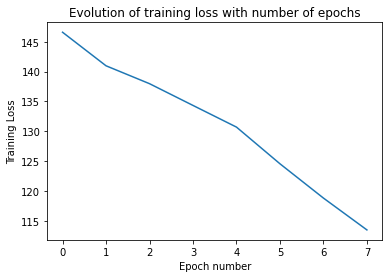

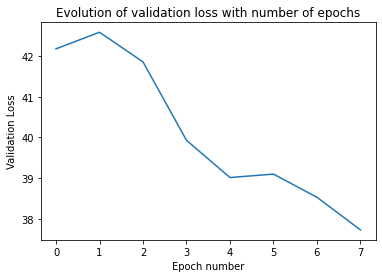

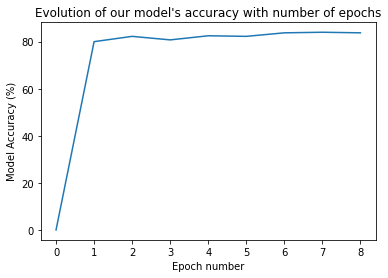

In [ ]:
model = train(model, loss_fn=nn.CrossEntropyLoss(), epochs=8, batch_size=4)

In [ ]:
loader = DataLoader(data_test, batch_size = 1, shuffle=True) 
success_rate(model, data=loader, batch_size=1)

86.0

We can now save our model.

In [ ]:
 torch.save(model.state_dict(), "model_from_scratch_1.h5")

#**ResNet 152 Model**

In the following section we present a different approach, as we fine-tune pre-trained models to adapt them to our problem. This is known as transfer learning. Just like before, we will start by importing useful Python libraries and train the model with our training dataset and evaluate its performance on validation and test datasets.

In [663]:
# Importing useful libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

As the previous section, only uncomment and run this code if needed.

In [ ]:
#drive.mount('/content/content/Drive/')
#zip_ref = zipfile.ZipFile("/content/Drive/My Drive/imgs/ai_ready.zip")
#zip_ref.extractall("/tmp")
#zip_ref.close()

We will now download a pre-trained ResNet 50 model, freeze all layers but the last one and adapt its last layers to have 2 out-classes.

In [664]:
# Downloading pre-trained ResNet 150 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [665]:
# Freezing feature parameters
for param in model.parameters():
  param.requires_grad = False

# Adding one ReLU and Linear layers to get 2 out features
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [ ]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

Again like before, we create our datasets, train and evaluate our models.

In [ ]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, transform = transforms.Compose([transforms.Resize((224, 224)),
                                                                                     transforms.ToTensor(),transforms.Normalize(mean, std)])):
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.transform = transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
        
      if self.transform:
        image = self.transform(image)

      return image, label

In [ ]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img)
data_validation = Data(csv_validation, image_dir=img)
data_test = Data(csv_test, image_dir=img)

In [ ]:
# Calculating loss
def calculate_loss(model, dataloader, batch_size=16):
    loss_fn = nn.CrossEntropyLoss()
    loss_epoch_test = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_test += loss
            
    return loss_epoch_test.item()

In [ ]:
# Calculating success rate
def success_rate(model, data, batch_size):
    N = len(data)
    counter = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            target = torch.zeros((min(len(labels), batch_size)))
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            
            i=0
            
            for output in outputs:
                if torch.argmax(output) == target[i]:
                    counter = counter + 1
                i = i + 1
                
            l = len(target)
          
    rate = (counter / ((N-1) * batch_size + l)) * 100

    return rate

In [ ]:
# Setting our device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training the model
def train(model, loss_fn, epochs, batch_size):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle=True)
    dataloader_validation = DataLoader(data_validation, batch_size = batch_size, shuffle=True) 
    training_loss = []
    validation_loss = []
    success_rate_ = [0]

    for epoch in tqdm(range(epochs), desc = "Total Progress: "):
        loss_epoch_train = 0
        
        for inputs, labels in dataloader_train:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]

            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
      
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_train += loss
            loss.backward()
            optimizer.step()
            
        print("Training Loss: {0}".format(loss_epoch_train.cpu().detach()))
        training_loss.append(loss_epoch_train.cpu().detach())
    
        val_loss = calculate_loss(model, dataloader_validation, batch_size)
        print("Validation Loss: {0}".format(val_loss))
        validation_loss.append(val_loss)
     
        accuracy_rate = success_rate(model, dataloader_validation, batch_size)
        print("Model accuracy: {0} %".format(accuracy_rate))
        success_rate_.append(accuracy_rate)
        
        print("Epoch done.")
        print("-------------------------------------")
            
    
    plt.plot(training_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Training Loss")
    plt.title("Evolution of training loss with number of epochs")
    plt.show()
    
    plt.plot(validation_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Validation Loss")
    plt.title("Evolution of validation loss with number of epochs")
    plt.show()
    
    plt.plot(success_rate_)
    plt.xlabel("Epoch number")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Evolution of our model's accuracy with number of epochs")
    plt.show()
    
    return model

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 180.0915985107422
Validation Loss: 39.86483383178711
Model accuracy: 85.75 %
Epoch done.
-------------------------------------
Training Loss: 128.68923950195312
Validation Loss: 33.0706787109375
Model accuracy: 88.5 %
Epoch done.
-------------------------------------
Training Loss: 111.6136474609375
Validation Loss: 31.264421463012695
Model accuracy: 89.5 %
Epoch done.
-------------------------------------
Training Loss: 102.26875305175781
Validation Loss: 28.307645797729492
Model accuracy: 89.75 %
Epoch done.
-------------------------------------
Training Loss: 95.53460693359375
Validation Loss: 27.692716598510742
Model accuracy: 90.25 %
Epoch done.
-------------------------------------
Training Loss: 90.80806732177734
Validation Loss: 26.75977325439453
Model accuracy: 90.75 %
Epoch done.
-------------------------------------
Training Loss: 87.91461944580078
Validation Loss: 25.915241241455078
Model accuracy: 90.75 %
Epoch done.
-------------------------------------
Tra

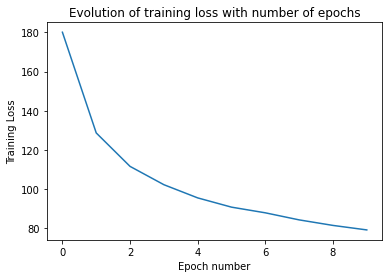

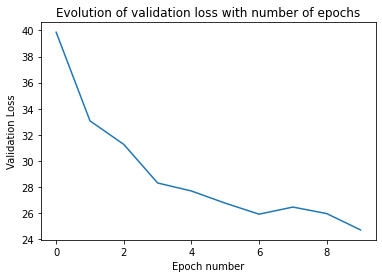

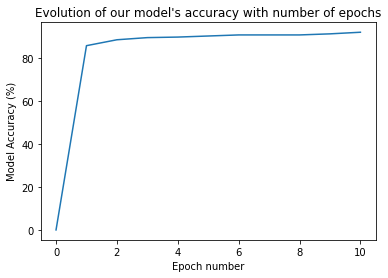

In [ ]:
model = train(model, loss_fn=nn.CrossEntropyLoss(), epochs=10, batch_size=4)

In [ ]:
loader = DataLoader(data_test, batch_size = 1, shuffle=True) 
success_rate(model, data=loader, batch_size=1)

92.0

We save our trained model in order to use it later.

In [ ]:
 torch.save(model.state_dict(), "resnet152_model.h5")

#**AlexNet Model**

The following section is similar to the one before, as we fine-tune another type of pre-trained model: AlexNet.

In [ ]:
# Importing useful libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

In [ ]:
#drive.mount('/content/content/Drive/')
#zip_ref = zipfile.ZipFile("/content/Drive/My Drive/imgs/ai_ready.zip")
#zip_ref.extractall("/tmp")
#zip_ref.close()

In [ ]:
# Downloading pre-trained AlexNet model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freezing feature parameters
for param in model.parameters():
  param.requires_grad = False

model.classifier[-1] = nn.Linear(in_features=4096, out_features=2, bias=True)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [ ]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

In [ ]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, transform = transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(mean, std)])):
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.transform = transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
        
      if self.transform:
        image = self.transform(image)

      return image, label

In [ ]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img)
data_validation = Data(csv_validation, image_dir=img)
data_test = Data(csv_test, image_dir=img)

In [ ]:
# Calculating loss
def calculate_loss(model, dataloader, batch_size=16):
    loss_fn = nn.CrossEntropyLoss()
    loss_epoch_test = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_test += loss
            
    return loss_epoch_test.item()

In [ ]:
# Calculating success rate
def success_rate(model, data, batch_size):
    N = len(data)
    counter = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            target = torch.zeros((min(len(labels), batch_size)))
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            
            i=0
            
            for output in outputs:
                if torch.argmax(output) == target[i]:
                    counter = counter + 1
                i = i + 1
                
            l = len(target)
          
    rate = (counter / ((N-1) * batch_size + l)) * 100

    return rate

In [ ]:
# Setting our device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training the model
def train(model, loss_fn, epochs, batch_size):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle=True)
    dataloader_validation = DataLoader(data_validation, batch_size = batch_size, shuffle=True) 
    training_loss = []
    validation_loss = []
    success_rate_ = [0]

    for epoch in tqdm(range(epochs), desc = "Total Progress: "):
        loss_epoch_train = 0
        
        for inputs, labels in dataloader_train:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]

            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
      
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_train += loss
            loss.backward()
            optimizer.step()
            
        print("Training Loss: {0}".format(loss_epoch_train.cpu().detach()))
        training_loss.append(loss_epoch_train.cpu().detach())
    
        val_loss = calculate_loss(model, dataloader_validation, batch_size)
        print("Validation Loss: {0}".format(val_loss))
        validation_loss.append(val_loss)
     
        accuracy_rate = success_rate(model, dataloader_validation, batch_size)
        print("Model accuracy: {0} %".format(accuracy_rate))
        success_rate_.append(accuracy_rate)
        
        print("Epoch done.")
        print("-------------------------------------")
            
    
    plt.plot(training_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Training Loss")
    plt.title("Evolution of training loss with number of epochs")
    plt.show()
    
    plt.plot(validation_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Validation Loss")
    plt.title("Evolution of validation loss with number of epochs")
    plt.show()
    
    plt.plot(success_rate_)
    plt.xlabel("Epoch number")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Evolution of our model's accuracy with number of epochs")
    plt.show()
    
    return model

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 169.82809448242188
Validation Loss: 38.28880310058594
Model accuracy: 87.25 %
Epoch done.
-------------------------------------
Training Loss: 117.14905548095703
Validation Loss: 33.3648681640625
Model accuracy: 88.25 %
Epoch done.
-------------------------------------
Training Loss: 100.61040496826172
Validation Loss: 32.18662643432617
Model accuracy: 86.0 %
Epoch done.
-------------------------------------
Training Loss: 88.47106170654297
Validation Loss: 31.93255043029785
Model accuracy: 87.75 %
Epoch done.
-------------------------------------
Training Loss: 81.17259216308594
Validation Loss: 31.23692512512207
Model accuracy: 86.75 %
Epoch done.
-------------------------------------
Training Loss: 73.2423095703125
Validation Loss: 31.43621826171875
Model accuracy: 86.0 %
Epoch done.
-------------------------------------
Training Loss: 68.50291442871094
Validation Loss: 31.809240341186523
Model accuracy: 88.25 %
Epoch done.
-------------------------------------
Traini

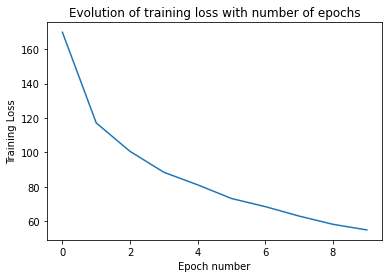

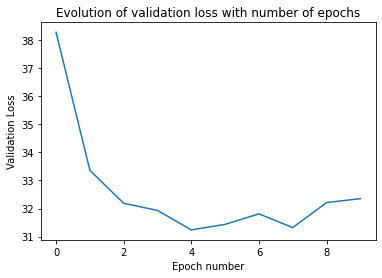

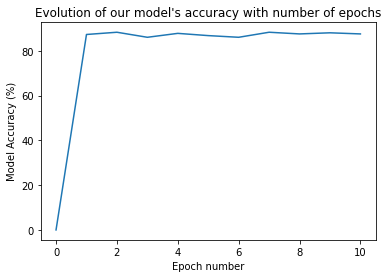

In [ ]:
model = train(model, loss_fn=nn.CrossEntropyLoss(), epochs=10, batch_size=4)

In [ ]:
loader = DataLoader(data_test, batch_size = 1, shuffle=True) 
success_rate(model, data=loader, batch_size=1)

89.0

In [ ]:
 torch.save(model.state_dict(), "alexnet_model.h5")

#**ResNet 50 Model**

Another pre-trained model that can be fine-tuned is the ResNet50 Model. Again, we proceed as we did with the other pre-trained models.

In [ ]:
# Importing useful libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

In [ ]:
#drive.mount('/content/content/Drive/')
#zip_ref = zipfile.ZipFile("/content/Drive/My Drive/imgs/ai_ready.zip")
#zip_ref.extractall("/tmp")
#zip_ref.close()

In [ ]:
# Downloading pre-trained ResNet 50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freezing feature parameters
for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [ ]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

In [ ]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, transform = transforms.Compose([transforms.Resize((224, 224)),
                                                                                     transforms.ToTensor(),transforms.Normalize(mean, std)])):
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.transform = transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
        
      if self.transform:
        image = self.transform(image)

      return image, label

In [ ]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img)
data_validation = Data(csv_validation, image_dir=img)
data_test = Data(csv_test, image_dir=img)

In [ ]:
# Calculating loss
def calculate_loss(model, dataloader, batch_size=16):
    loss_fn = nn.CrossEntropyLoss()
    loss_epoch_test = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            target = target.type(torch.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_test += loss
            
    return loss_epoch_test.item()

In [ ]:
# Calculating success rate
def success_rate(model, data, batch_size):
    N = len(data)
    counter = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            target = torch.zeros((min(len(labels), batch_size)))
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            
            i=0
            
            for output in outputs:
                if torch.argmax(output) == target[i]:
                    counter = counter + 1
                i = i + 1
                
            l = len(target)
          
    rate = (counter / ((N-1) * batch_size + l)) * 100

    return rate

In [ ]:
# Setting our device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training the model
def train(model, loss_fn, epochs, batch_size):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle=True)
    dataloader_validation = DataLoader(data_validation, batch_size = batch_size, shuffle=True) 
    training_loss = []
    validation_loss = []
    success_rate_ = [0]

    for epoch in tqdm(range(epochs), desc = "Total Progress: "):
        loss_epoch_train = 0
        
        for inputs, labels in dataloader_train:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]

            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
      
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_train += loss
            loss.backward()
            optimizer.step()
            
        print("Training Loss: {0}".format(loss_epoch_train.cpu().detach()))
        training_loss.append(loss_epoch_train.cpu().detach())
    
        val_loss = calculate_loss(model, dataloader_validation, batch_size)
        print("Validation Loss: {0}".format(val_loss))
        validation_loss.append(val_loss)
     
        accuracy_rate = success_rate(model, dataloader_validation, batch_size)
        print("Model accuracy: {0} %".format(accuracy_rate))
        success_rate_.append(accuracy_rate)
        
        print("Epoch done.")
        print("-------------------------------------")
            
    
    plt.plot(training_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Training Loss")
    plt.title("Evolution of training loss with number of epochs")
    plt.show()
    
    plt.plot(validation_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Validation Loss")
    plt.title("Evolution of validation loss with number of epochs")
    plt.show()
    
    plt.plot(success_rate_)
    plt.xlabel("Epoch number")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Evolution of our model's accuracy with number of epochs")
    plt.show()
    
    return model

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 183.8868408203125
Validation Loss: 43.78961181640625
Model accuracy: 84.75 %
Epoch done.
-------------------------------------
Training Loss: 135.6058349609375
Validation Loss: 35.55256652832031
Model accuracy: 89.0 %
Epoch done.
-------------------------------------
Training Loss: 116.8226318359375
Validation Loss: 32.001216888427734
Model accuracy: 89.5 %
Epoch done.
-------------------------------------
Training Loss: 107.3238754272461
Validation Loss: 29.842653274536133
Model accuracy: 89.75 %
Epoch done.
-------------------------------------
Training Loss: 100.71686553955078
Validation Loss: 28.34601593017578
Model accuracy: 90.5 %
Epoch done.
-------------------------------------
Training Loss: 94.81629943847656
Validation Loss: 27.668031692504883
Model accuracy: 91.5 %
Epoch done.
-------------------------------------
Training Loss: 89.7990493774414
Validation Loss: 26.050743103027344
Model accuracy: 91.25 %
Epoch done.
-------------------------------------
Traini

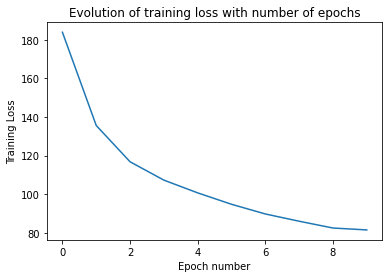

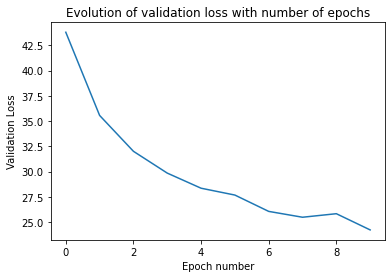

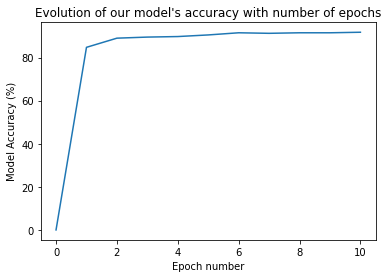

In [ ]:
model = train(model, loss_fn=nn.CrossEntropyLoss(), epochs=10, batch_size=4)

In [ ]:
loader = DataLoader(data_test, batch_size = 1, shuffle=True) 
success_rate(model, data=loader, batch_size=1)

89.5

In [ ]:
 torch.save(model.state_dict(), "resnet50_model.h5")

#**VGG-16 Model**

In [ ]:
# Importing useful libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

In [ ]:
#drive.mount('/content/content/Drive/')
#zip_ref = zipfile.ZipFile("/content/Drive/My Drive/imgs/ai_ready.zip")
#zip_ref.extractall("/tmp")
#zip_ref.close()

In [ ]:
# Downloading pre-trained VGG 16 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Freezing feature parameters
for param in model.parameters():
  param.requires_grad = False

model.classifier[-1] = nn.Linear(in_features=4096, out_features=2, bias=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [ ]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

In [ ]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, transform = transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(mean, std)])):
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.transform = transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
        
      if self.transform:
        image = self.transform(image)

      return image, label

In [ ]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img)
data_validation = Data(csv_validation, image_dir=img)
data_test = Data(csv_test, image_dir=img)

In [ ]:
# Calculating loss
def calculate_loss(model, dataloader, batch_size=16):
    loss_fn = nn.CrossEntropyLoss()
    loss_epoch_test = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
                
            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_test += loss
            
    return loss_epoch_test.item()

In [ ]:
# Calculating success rate
def success_rate(model, data, batch_size):
    N = len(data)
    counter = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            target = torch.zeros((min(len(labels), batch_size)))
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]
            
            i=0
            
            for output in outputs:
                if torch.argmax(output) == target[i]:
                    counter = counter + 1
                i = i + 1
                
            l = len(target)
          
    rate = (counter / ((N-1) * batch_size + l)) * 100

    return rate

In [ ]:
# Setting our device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training the model
def train(model, loss_fn, epochs, batch_size):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle=True)
    dataloader_validation = DataLoader(data_validation, batch_size = batch_size, shuffle=True) 
    training_loss = []
    validation_loss = []
    success_rate_ = [0]

    for epoch in tqdm(range(epochs), desc = "Total Progress: "):
        loss_epoch_train = 0
        
        for inputs, labels in dataloader_train:
            target = torch.zeros((min(len(labels), batch_size)))
    
            for i in range(min(len(labels), batch_size)):
                target[i] = labels[i]

            target = target.type(torch.cuda.LongTensor)
            target = target.to(device)
    
            inputs = inputs.type(torch.cuda.FloatTensor)
            inputs = inputs.to(device)
      
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            loss_epoch_train += loss
            loss.backward()
            optimizer.step()
            
        print("Training Loss: {0}".format(loss_epoch_train.cpu().detach()))
        training_loss.append(loss_epoch_train.cpu().detach())
    
        val_loss = calculate_loss(model, dataloader_validation, batch_size)
        print("Validation Loss: {0}".format(val_loss))
        validation_loss.append(val_loss)
     
        accuracy_rate = success_rate(model, dataloader_validation, batch_size)
        print("Model accuracy: {0} %".format(accuracy_rate))
        success_rate_.append(accuracy_rate)
        
        print("Epoch done.")
        print("-------------------------------------")
            
    
    plt.plot(training_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Training Loss")
    plt.title("Evolution of training loss with number of epochs")
    plt.show()
    
    plt.plot(validation_loss)
    plt.xlabel("Epoch number")
    plt.ylabel("Validation Loss")
    plt.title("Evolution of validation loss with number of epochs")
    plt.show()
    
    plt.plot(success_rate_)
    plt.xlabel("Epoch number")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Evolution of our model's accuracy with number of epochs")
    plt.show()
    
    return model

Total Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 151.4239959716797
Validation Loss: 35.99698257446289
Model accuracy: 85.25 %
Epoch done.
-------------------------------------
Training Loss: 103.34427642822266
Validation Loss: 31.775541305541992
Model accuracy: 87.0 %
Epoch done.
-------------------------------------
Training Loss: 88.96426391601562
Validation Loss: 30.273181915283203
Model accuracy: 87.5 %
Epoch done.
-------------------------------------
Training Loss: 81.77999114990234
Validation Loss: 29.342124938964844
Model accuracy: 88.25 %
Epoch done.
-------------------------------------
Training Loss: 75.99425506591797
Validation Loss: 28.81694221496582
Model accuracy: 88.0 %
Epoch done.
-------------------------------------
Training Loss: 71.03302764892578
Validation Loss: 28.554323196411133
Model accuracy: 87.75 %
Epoch done.
-------------------------------------
Training Loss: 66.63579559326172
Validation Loss: 28.767471313476562
Model accuracy: 88.0 %
Epoch done.
-------------------------------------
Trai

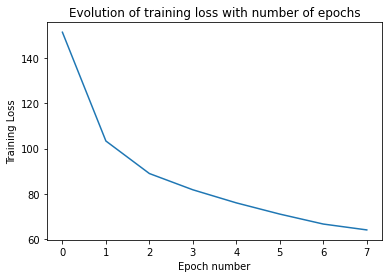

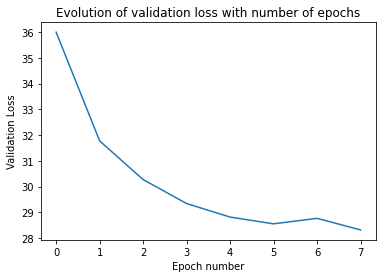

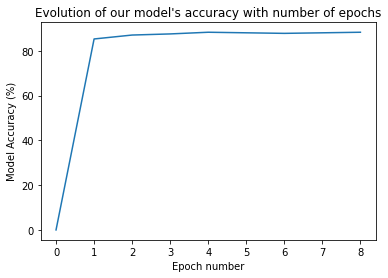

In [ ]:
model = train(model, loss_fn=nn.CrossEntropyLoss(), epochs=8, batch_size=4)

In [ ]:
loader = DataLoader(data_test, batch_size = 1, shuffle=True) 
success_rate(model, data=loader, batch_size=1)

89.5

In [ ]:
 torch.save(model.state_dict(), "vgg16_model.h5")

#**Model Evaluation**

Here we evaluate the performance of the model that we created from scratch, computing its confusion matrix.

In [657]:
def conf_mat(model, test_data, batch_size):
    nb_classes = 2
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    dataloader_test = DataLoader(test_data, batch_size = batch_size, shuffle=True)

    model = model.to(device)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader_test, desc = "Total Progress: "):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            outputs = model(inputs)

            for i in range(min(len(outputs), batch_size)):
                pred = torch.argmax(outputs[i]).item()
                confusion_matrix[labels[i]][pred] += 1
    
    plt.figure(figsize=(7,5))
    class_names = ["Contains Silo", "Does Not Contain Silo"]
    
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize = 8)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize = 8)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    plt.show()

In [658]:
# Creating model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc1 = nn.Linear(128 * 3 * 3, 1000)
        self.fc2 = nn.Linear(1000, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

model = Net()
model.load_state_dict(torch.load("model_from_scratch_1.h5"))

<All keys matched successfully>

Total Progress:   0%|          | 0/200 [00:00<?, ?it/s]

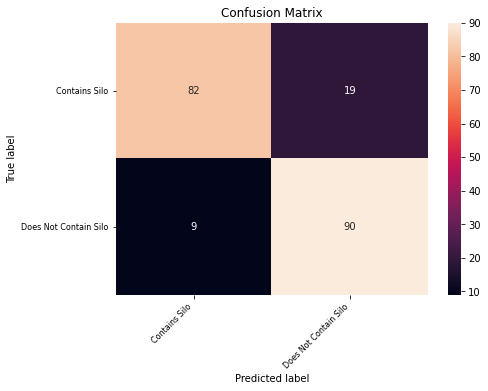

In [659]:
conf_mat(model, data_test, batch_size = 1)

We can clearly see that the model performs well globally, but has a tendency to miss some images containing silos.

We will now try evaluating the performance of the ResNet 152 model, one of our best ones in terms of precision on validation and test datasets.

In [666]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [667]:
model.load_state_dict(torch.load("resnet152_model.h5"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Total Progress:   0%|          | 0/200 [00:00<?, ?it/s]

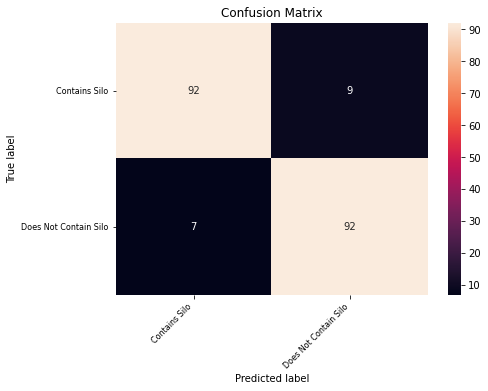

In [668]:
conf_mat(model, data_test, batch_size=1)

We can see that this model performs better on our dataset, as the errors made (false positives and false negatives) are somewhat balanced.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.load_state_dict(torch.load("resnet152_model.h5"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.load_state_dict(torch.load("resnet152_model.h5"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Total Progress:   0%|          | 0/200 [00:00<?, ?it/s]

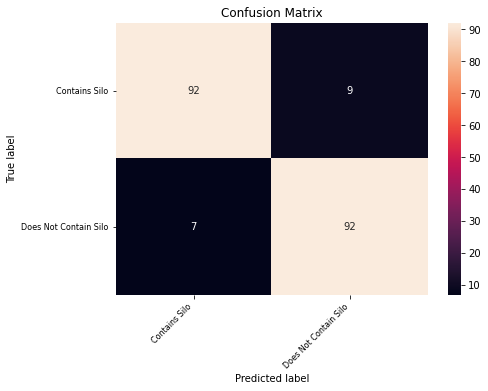

In [ ]:
conf_mat(model, data_test, batch_size=1)

We can see that this model performs better on our dataset, as the errors made (false positives and false negatives) are somewhat balanced.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.load_state_dict(torch.load("resnet152_model.h5"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#**Image Segmentation**

In this final section we tackle the image segmentation problem. The goal is to return a mask of the image, localizing silos if they exist.

In [675]:
# Importing useful libraries
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchmetrics import JaccardIndex
from PIL import Image
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import zipfile

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as tools

In [676]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Here we defined our model, with the ResNet 50 model being used as an encoder. Pre-trained weights from imagenet are also downloaded.

In [677]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Now we create our datasets for training and evaluating performance.

In [678]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [679]:
csv_train ="df_train.csv"
csv_validation = "df_validation.csv"
csv_test =  "df_test.csv"
img = "/tmp/ai_ready/images"
mask = "/tmp/ai_ready/masks"

In [680]:
# Creation of a dataset class
class Data(Dataset):
    def __init__(self, csv_to_read, image_dir = img, mask_dir = mask, 
                 transform_mask = transforms.Compose([transforms.ToTensor()]),
                 transform_img =transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])):
      
      self.img_labels = pd.read_csv(csv_to_read)
      self.img_dir = image_dir
      self.mask_dir = mask_dir
      self.transform_mask = transform_mask
      self.transform_img = transform_img

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      label = self.img_labels['class'].to_list()[idx]
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      mask_path = os.path.join(self.mask_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
      mask = Image.open(mask_path)
        
      image = self.transform_img(image)

      mask = self.transform_mask(mask)

      return image, mask

    def show_image(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels['filename'].to_list()[idx])
      image = Image.open(img_path)
      image.show()
      display(image)

    def show_mask(self, idx):
      mask_path = os.path.join(self.mask_dir, self.img_labels['filename'].to_list()[idx])
      mask = Image.open(mask_path)
      mask.show()
      display(mask)


In [681]:
# Creating our dataset
data_train = Data(csv_train, image_dir=img, mask_dir=mask)
data_validation = Data(csv_validation, image_dir=img, mask_dir=mask)
data_test = Data(csv_test, image_dir=img, mask_dir=mask)

In [684]:
train_loader = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(data_validation, batch_size=1, shuffle=False, num_workers=4)

Here we set the important parameters, functions and optimizers for the training process of our model.

In [685]:
# Set num of epochs
EPOCHS = 10

# define loss function
loss = tools.losses.DiceLoss()

# define metrics
metrics = [
    tools.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [686]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [687]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)


Epoch: 0
valid: 100%|██████████| 400/400 [00:09<00:00, 42.06it/s, dice_loss - 0.9577, iou_score - 0.1958]

Epoch: 1
valid: 100%|██████████| 400/400 [00:10<00:00, 37.99it/s, dice_loss - 0.9438, iou_score - 0.6158]

Epoch: 2
valid: 100%|██████████| 400/400 [00:09<00:00, 42.02it/s, dice_loss - 0.9183, iou_score - 0.463]

Epoch: 3
valid: 100%|██████████| 400/400 [00:10<00:00, 39.43it/s, dice_loss - 0.8799, iou_score - 0.5686]

Epoch: 4
valid: 100%|██████████| 400/400 [00:10<00:00, 37.20it/s, dice_loss - 0.831, iou_score - 0.65]

Epoch: 5
valid: 100%|██████████| 400/400 [00:09<00:00, 40.29it/s, dice_loss - 0.8104, iou_score - 0.5874]

Epoch: 6
valid: 100%|██████████| 400/400 [00:09<00:00, 41.59it/s, dice_loss - 0.7676, iou_score - 0.7291]

Epoch: 7
valid: 100%|██████████| 400/400 [00:09<00:00, 41.14it/s, dice_loss - 0.7329, iou_score - 0.7214]

Epoch: 8
valid: 100%|██████████| 400/400 [00:09<00:00, 41.73it/s, dice_loss - 0.7662, iou_score - 0.7069]

Epoch: 9
valid: 100%|██████████| 400/400

We now visualize the IoU score and the dice loss plots to gain better understanding of the performance of the model.

In [689]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

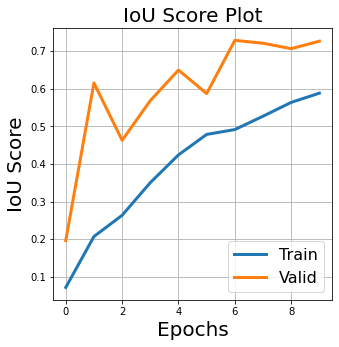

In [690]:
plt.figure(figsize=(5,5))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

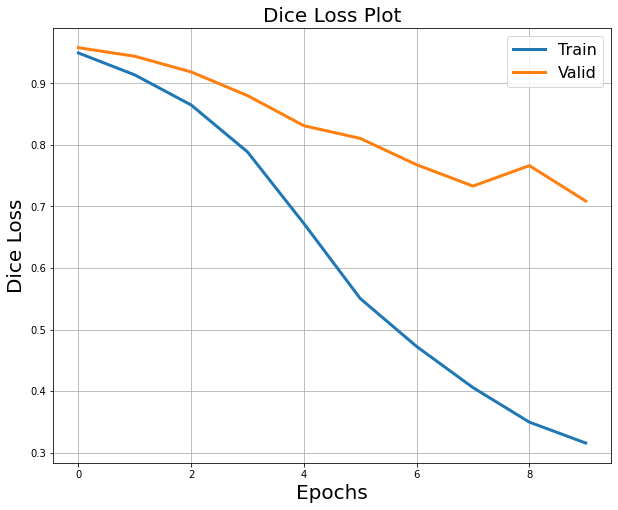

In [692]:
plt.figure(figsize=(10,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [ ]:
torch.save(model, './segmentation_model.pth')